In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [52]:
from lib import jsoncorpus, datastuff, analysis
import gensim
import traceback
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline, FeatureUnion
import sklearn.preprocessing
import sklearn.cross_validation
import sklearn.ensemble
import sklearn.svm
import sklearn.decomposition
from lib.scikitComponents import *
import itertools
import collections

# LDA

## Data preprocessing

In [20]:
# Load in the previously created corpus and dictionary of scraped sites
dictionary, corpus, meta_corpus, dmoz_data = jsoncorpus.load_or_create('docs/sites.jl')

Done.


In [32]:
X = zip(dmoz_data["meta"], list(corpus))

In [22]:
# Link topics to URLs
meta = list(zip(dmoz_data['urls'], dmoz_data['dmoz_categories']))

## Define a classification pipeline for the corpus data

The Pipeline() object chains together objects from the lib.scikitComponents file, so that they can be used as part of a scikit-learn classification pipeline

Define a classifier (decision trees), and chain the preprocessing step to the classifier

In [40]:
# classifier = sklearn.svm.LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
#      intercept_scaling=1, loss='squared_hinge', max_iter=1000,
#      multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
#      verbose=0)

# classifier = sklearn.svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3,
# gamma=0.0, kernel='rbf', max_iter=-1, probability=False, random_state=None,
# shrinking=True, tol=0.001, verbose=False)

classes, top_categories, dmoz_encoder = datastuff.encode_dmoz_categories(dmoz_data['dmoz_categories'])

num_lda_topics = 15
meta_pipeline = Pipeline([
    ('meta_picker', ItemPicker(0)),
    ('matrix_builder', MetaMatrixBuilder())
])
body_pipeline = Pipeline([
    ('meta_picker', ItemPicker(1)),
    ('lda_model', LDAModel(dictionary, num_lda_topics)),
    ('matrix_builder', TopicMatrixBuilder(num_lda_topics))
])
classifier = sklearn.ensemble.ExtraTreesClassifier(random_state=0, n_estimators=100, oob_score=True, bootstrap=True, n_jobs=4)

union = FeatureUnion([("meta", meta_pipeline), ("body", body_pipeline)])

clf = Pipeline([('features', union), ('classifier', classifier)])


## Run the classifier

We can use the meta corpus or the full body corpus here, just by replacing a single argument

The data is split in to training and test sets, and then fit to the training set. The LDA model is generated ***only*** from the training set, not the testing set.

In [41]:
scores = sklearn.cross_validation.cross_val_score(clf, X, classes, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.38 (+/- 0.04)


In [43]:
X_train, X_test, y_train, y_test = sklearn.cross_validation.train_test_split(np.array(X), classes)
model = clf.fit(X_train, y_train)
print model.score(X_test, y_test)

0.461666666667


### Find the score for each category. 

Note that if the classifier assigned *random* categories, the score would be $\frac{1}{\textrm{num categories}}$. Instead, it is actually quite high in some cases, indicating a moderate amount of success (given how naive this is!)

             precision    recall  f1-score   support

       arts       0.31      0.35      0.33        34
   business       0.39      0.50      0.44        48
  computers       0.39      0.59      0.47        49
      games       0.60      0.33      0.43        18
     health       0.44      0.50      0.47        34
       home       0.41      0.50      0.45        32
kids and teens       0.33      0.10      0.15        10
       news       0.58      0.50      0.54        36
 recreation       0.35      0.14      0.20        44
  reference       0.62      0.30      0.40        61
   regional       0.00      0.00      0.00         2
    science       0.41      0.38      0.40        55
   shopping       0.67      0.62      0.64        26
    society       0.29      0.11      0.16        53
     sports       0.55      0.90      0.68        98

avg / total       0.46      0.46      0.43       600



/Library/Python/2.7/site-packages/IPython/kernel/__main__.py:4: RuntimeWarning: divide by zero encountered in log


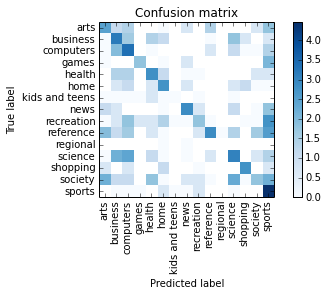

[[12  3  4  0  0  1  0  2  0  4  0  0  0  2  6]
 [ 1 24  5  0  4  3  0  0  0  1  0  6  2  0  2]
 [ 1  7 29  0  1  0  0  0  0  2  0  3  1  1  4]
 [ 1  0  0  6  0  1  0  2  0  0  0  0  0  0  8]
 [ 0  4  4  0 17  3  0  1  1  0  0  0  0  2  2]
 [ 0  2  3  0  2 16  0  2  0  0  0  2  3  1  1]
 [ 1  1  1  1  2  1  1  0  1  0  0  1  0  0  0]
 [ 3  2  0  0  0  1  0 18  2  0  0  3  0  1  6]
 [ 1  2  6  2  2  4  1  1  6  1  0  0  1  1 16]
 [ 7  3  5  0  2  1  0  0  2 18  1  4  0  5 13]
 [ 0  0  0  0  0  1  0  1  0  0  0  0  0  0  0]
 [ 1  9 11  0  3  1  0  1  0  2  0 21  0  2  4]
 [ 2  0  2  0  0  3  0  0  1  0  0  0 16  0  2]
 [ 9  3  3  0  6  1  0  2  2  1  0 10  1  6  9]
 [ 0  1  1  1  0  2  1  1  2  0  0  1  0  0 88]]


In [58]:
predicted = model.predict(X_test)
print sklearn.metrics.classification_report(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)
cm = sklearn.metrics.confusion_matrix(dmoz_encoder.inverse_transform(y_test), dmoz_encoder.inverse_transform(predicted), dmoz_encoder.classes_)
analysis.plot_confusion_matrix(np.log(cm), labels= dmoz_encoder.classes_)
plt.show()
print cm